In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import geeksw.plotting.cmsplot as plt
from libwwz import wwz_plotting
import uproot_methods

In [4]:
import libwwz
libwwz.config.year = 2018

In [5]:
import uproot
import os
import numpy as np
import pandas as pd

In [6]:
from geeksw.utils.core import concatenate
from geeksw.utils.data_loader_tools import make_data_loader, TreeWrapper, list_root_files_recursively

In [18]:
def analyze_dataset(year, short_name, override_path=None, scale=1.):
    df_full = libwwz.utils.load_four_lepton_skim(year, short_name)
    
    return libwwz.four_lepton_analysis.four_lepton_analysis(df_full, use_z_id_as_w_id=True)

In [19]:
samples_info = {"wwz" : [(2016, "WWZ_incl"), # skim validated for all years
                         (2017, "WWZ_4l"),
                         (2018, "WWZ_4l")],
                "ttz" : [(2016, "TTZnlo_ext2"), # skim validated for all years
                         (2017, "TTZnlo"),
                         (2018, "TTZnlo"),
                        (2016, "TTZLOW"),
                         (2017, "TTZLOW"),
                         (2018, "TTZLOW")],
                "zz" : [(2016, "ZZ"), (2017, "ZZ"), (2018, "ZZ_ext1")],
               "wz" : [(2016, "WZ"), (2017, "WZ"), (2018, "WZ")],
               "twz" : [(2016, "TWZ"), (2017, "TWZ"), (2018, "TWZ")],
               "othernoh" : [(2016, "DY_high"), (2017, "DY_high"), (2018, "DY_high")]}

In [75]:
def analyze_data():
    dfs = []
    paths = ["/scratch/skims/data/2016/data_Run2016Bv1_ee/four_lepton_skim",
            "/scratch/skims/data/2016/data_Run2016Bv2_ee/four_lepton_skim",
            "/scratch/skims/data/2016/data_Run2016C_ee/four_lepton_skim",
             "/scratch/skims/data/2016/data_Run2016D_ee/four_lepton_skim",
             "/scratch/skims/data/2016/data_Run2016E_ee/four_lepton_skim",
             "/scratch/skims/data/2016/data_Run2016F_ee/four_lepton_skim",
             "/scratch/skims/data/2017/data_Run2017B_ee/four_lepton_skim",
             "/scratch/skims/data/2017/data_Run2017C_ee/four_lepton_skim",
             "/scratch/skims/data/2017/data_Run2017D_ee/four_lepton_skim",
             "/scratch/skims/data/2017/data_Run2017E_ee/four_lepton_skim",
             "/scratch/skims/data/2017/data_Run2017F_ee/four_lepton_skim",
            "/scratch/skims/data/2018/EGamma_2018A/four_lepton_skim",
            ]
    for path in paths:
        df_full = libwwz.utils.load_four_lepton_skim(None, None, override_path=path)
        dfs.append(libwwz.four_lepton_analysis.four_lepton_analysis(df_full, use_z_id_as_w_id=True))
        
    return pd.concat(dfs, ignore_index=True, axis=0)

In [21]:
def analyze_sample(sample_name):
    dfs = []
    for tup in samples_info[sample_name]:
        scale = 1.
        if len(tup) == 2:
            year, short_name = tup
        else:
            year, short_name, scale = tup
        dfs.append(analyze_dataset(year, short_name, scale=scale))
    return pd.concat(dfs, ignore_index=True)

In [22]:
ls /scratch/skims/mc/2018

DY_high/      TTWnlo/  VHtoNonBB/  WZZ_incl/          ZZcontTo4tau/
DY_low/       TTWW/    WWW_2l/     ZZcontTo2e2mu/     ZZcontTo4tau_ext/
DYzpt150/     TTWZ/    WWW_incl/   ZZcontTo2e2tau/    ZZ_ext1/
GGHtoZZto4L/  TTZH/    WWZ_4l/     ZZcontTo2mu2tau/   ZZ_ext2/
TTDL/         TTZLOW/  WWZ_incl/   ZZcontTo4e/        ZZZ_4l/
TTHtoNonBB/   TTZnlo/  WZ/         ZZcontTo4e_ext1/   ZZZ_incl/
TTSL/         TTZZ/    WZG/        ZZcontTo4mu/
TTWH/         TWZ/     WZZ_4l/     ZZcontTo4mu_ext1/


In [27]:
samples = {}
samples["wwz"] = analyze_sample("wwz")

In [85]:
samples["data"] = analyze_data()

In [29]:
samples["ttz"] = analyze_sample("ttz")

In [30]:
samples["zz"] = analyze_sample("zz")

In [31]:
samples["wz"] = analyze_sample("wz")
samples["twz"] = analyze_sample("twz")

In [32]:
samples["othernoh"] = analyze_sample("othernoh")

In [86]:
jagged_lepton_variable = libwwz.four_lepton_analysis.jagged_lepton_variable

for sample_name in samples:
    lep_pt = jagged_lepton_variable(samples[sample_name], "pt")
    samples[sample_name]["lep_min_pt"] = lep_pt.min()
    samples[sample_name]["lep_max_pt"] = lep_pt.max()
    samples[sample_name]["lep_min_iso"] = np.log(jagged_lepton_variable(samples[sample_name], "pfRelIso03_all_wLep").min())
    samples[sample_name]["lep_max_iso"] = np.log(jagged_lepton_variable(samples[sample_name], "pfRelIso03_all_wLep").max())
    
    samples[sample_name]["ZCand_mass_1"] = samples[sample_name]["ZCand_mass_1"].fillna(0.0)
    
    samples[sample_name]["sT"] = samples[sample_name]["veto_lepton_pt_sum"] + samples[sample_name]["MET_pt"]

/home/llr/cms/rembser/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/home/llr/cms/rembser/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


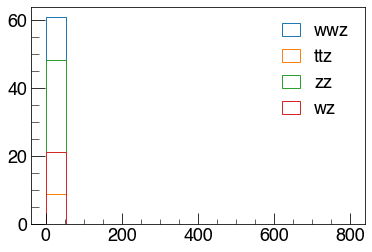

In [34]:

def clip(a, a_max=800):
    return np.clip(a, a_min=None, a_max=a_max)

bins = np.linspace(0, 800, 16)
#bins = np.linspace(0, 300, 46)

for sample_name in ["wwz", "ttz", "zz", "wz"]:
    #print(sample_name)
    #print(samples[sample_name].groupby("category")["weight"].sum())
    #print()
    df_q = samples[sample_name].query("category == 'EMu'")
    #print(sample_name, df_q["weight"].sum())

    plt.hist(clip(df_q["ZCand_mass_1"]),
    #plt.hist(clip(df_q["VetoLepton_pt_2"]),
    #plt.hist(clip(df_q["veto_lepton_pt_min"]),
             bins=bins,
             weights=np.clip(df_q["weight"], a_min=None, a_max=None),
             histtype="step",
             label=sample_name)
    
plt.legend(loc="upper right")

#plt.yscale('log', nonposy='clip')
plt.show()

In [35]:
samples["wz"].query("ZCand_mass_1 > 0")[['z_lep_1_idx', 'z_lep_2_idx', 'w_lep_1_idx', 'w_lep_2_idx']]

,z_lep_1_idx,z_lep_2_idx,w_lep_1_idx,w_lep_2_idx
2,0,3,1,2
10,1,2,0,3
11,0,1,2,3
19,0,1,2,3
21,0,3,1,2
...,...,...,...,...
9340,0,2,1,3
9344,1,2,0,3
9345,0,2,1,3
9346,0,1,2,3


/home/llr/cms/rembser/WWZ-leptonic-EFT-analysis/libwwz/wwz_plotting.py:192: RuntimeWarning: invalid value encountered in true_divide
  y = data_events / baseline_events
/home/llr/cms/rembser/WWZ-leptonic-EFT-analysis/libwwz/wwz_plotting.py:193: RuntimeWarning: invalid value encountered in true_divide
  yerr = data_errors2 ** 0.5 / baseline_events
/home/llr/cms/rembser/WWZ-leptonic-EFT-analysis/libwwz/wwz_plotting.py:206: RuntimeWarning: invalid value encountered in true_divide
  to_y((baseline_events - baseline_errors) / baseline_events),
/home/llr/cms/rembser/WWZ-leptonic-EFT-analysis/libwwz/wwz_plotting.py:207: RuntimeWarning: invalid value encountered in true_divide
  to_y((baseline_events + baseline_errors) / baseline_events),
No handles with labels found to put in legend.


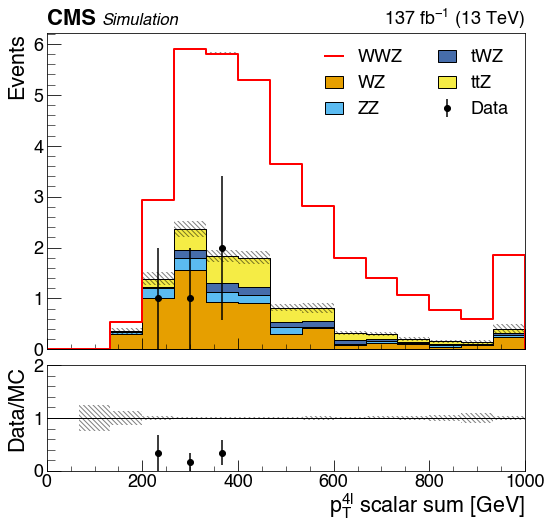

In [87]:
query = "category == 'EMu' and m_ll > 135"# and MET_pt < 50"
#query = "category == 'OffZ'"# and MET_pt < 50"
#query = "m_ll > 100"
#query = "not category == 'OnZ'"

bins = np.linspace(0, 1000, 16)
#bins = np.linspace(0, 500, 15)

wwz_plotting.wvz_hist(
    samples,
    "sT",
    #"m_ll",
    bins,
    #query="is_ChannelEMu",
    main_background="ttz",
    plot_data=True,
    data_scale=None,
    ratio_plot=True,
    xlabel=r"$p_T^{4l}$ scalar sum [GeV]",
    query=query,
    stack_signal_on_background=True,
    #ylim=(0,7.4),
    #log_scale=True,
)
#plt.show()
df_q = samples["wwz"].query(query)
#h = np.histogram(clip(df_q["sT"], a_max=bins[-1]), bins, weights=df_q["weight"])[0] * h_eft_scale
#plt.step(bins[1:], h, label=r"WWZ $f_{T0} = 1$ TeV${}^{-4}$")
plt.legend(loc="upper left")
plt.savefig("eft_plot.pdf")
plt.show()
plt.close()
#plt.ylim(0, 11)

In [37]:
h_eft_scale

NameError: name 'h_eft_scale' is not defined

In [ ]:
#df_wz = analyze_dataset(2018, "WZ")

In [ ]:
df_eft = analyze_dataset(None, None, override_path="/home/llr/cms/rembser/WWZ-leptonic-EFT-analysis/skims/2018_WWZ_dim8_four_lepton_skim")

In [ ]:
def get_weigth_scales_for_ft0(df, ft0_value):
    
    x = np.array([-10, -5.0, 0, 5.0, 10])
    xx = np.linspace(-10, 10, 200)
    weights = np.zeros(len(df))
    for i, y in enumerate(df[["EFT_FT0_m10", "EFT_FT0_m5", "EFT_SM", "EFT_FT0_5", "EFT_FT0_10"]].values):
        p = np.polyfit(x, y, 2)
        weights[i] = np.polyval(p, [ft0_value])
    return weights

In [ ]:
df_eft["sT"] = df_eft["veto_lepton_pt_sum"] + df_eft["MET_pt"]
df_eft_q = df_eft.query(query)

In [ ]:
plt.hist(df_eft_q["sT"], bins=bins);

In [228]:
scale_eft = get_weigth_scales_for_ft0(df_eft_q, 1.)

In [229]:
h_sm = np.histogram(clip(df_eft_q["sT"], a_max=bins[-1]), bins, weights=df_eft_q["genWeight"])[0]
h_eft = np.histogram(clip(df_eft_q["sT"], a_max=bins[-1]), bins, weights=df_eft_q["genWeight"] * scale_eft)[0]
h_eft_scale = h_eft / h_sm

/home/llr/cms/rembser/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [230]:
def get_n_high_mass_events(ft0_value):
    mass_cut = 1200.
    query = f"category == 'EMu' and veto_lepton_pt_sum > {mass_cut}"
    #query = f"veto_lepton_pt_sum > {mass_cut}"
    if ft0_value == 0.0:
        return df_wwz_4l.query(query)["weight"].sum()
    
    df_q = df.query(query)
    weights = get_weigth_scales_for_ft0(df_q, ft0_value)
    return np.sum(weights * df_q["weight"])

In [ ]:
def nll_term(s, b, n):
    return (s + b) - n * np.log(s + b)

In [ ]:
ft0_vals = np.linspace(-5, 5, 50)
n_events = np.array(list(map(get_n_high_mass_events, ft0_vals)))
nll = np.array(list(map(lambda n : nll_term(0, get_n_high_mass_events(0.0), n), n_events)))

In [ ]:
plt.plot(ft0_vals, nll)

In [ ]:
df["EFT_FT0_0p2"] = get_weigths_for_ft0(df, 0.2)